1. Build a regression model to predict the price of a house. You may choose between Ordinary Least Squares Regression, LASSO, Ridge or Elastic Net.

You may need to clean and transform the data, including feature engineering, creating dummy variables, or using dimensionality reduction.
Be sure to explain why you chose the approach you did, and why it's the best approach for the data provided.
2. Evaluate the model using techniques covered in class and explain the results. How do you know this is the best model you can build, given the tools you have?

3. Explain the results to a business executive. What are the main drivers of house prices in King City? And how much do these drivers impact the price?

In [626]:
import pandas as pd
import seaborn as sns
import pdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [627]:
house = pd.read_csv(r"C:\Users\Oscar_On\Downloads\kc_house_data.csv")

In [628]:
house['date'] = house['date'].str[:8]

house['date'] = pd.to_datetime(house['date'], format='%Y%m%d')

# Print the updated DataFrame
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [629]:
# Extract hour, month, day into new columns

house['month'] = house['date'].dt.month

house['day'] = house['date'].dt.day


In [630]:
# create function to show whether the house has been renovated

def ren(yr):
    if yr > 0:
        return 1
    else:
        return 0

In [631]:
# create column which shows renovation status of the house

house['reno'] = house['yr_renovated'].apply(ren)

In [632]:
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,reno
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,13,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,9,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,25,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,12,9,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,18,0


In [633]:
# drop column
columns_to_drop = ['id']
house = house.drop(columns_to_drop, axis = 1)

### Create testing 1 df

In [634]:
house_test1 = house

In [635]:
# Calculate the IQR for each column
Q1 = house_test1.quantile(0.25)
Q3 = house_test1.quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5

# Create a boolean mask to identify outlier rows for each column
outlier_mask = (house_test1 < (Q1 - threshold * IQR)) | (house > (Q3 + threshold * IQR))

# Drop rows with outliers for all columns
house_test1_cleaned = house_test1[~outlier_mask.any(axis=1)]

# Reset the index of the cleaned DataFrame
house_test1_cleaned.reset_index(drop=True, inplace=True)

# Describe the cleaned DataFrame
house_test1_cleaned.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,reno
count,14934,1.493400e+04,14934.000000,14934.000000,14934.000000,14934.000000,14934.000000,14934.0,14934.0,14934.000000,14934.00000,14934.000000,14934.000000,14934.000000,14934.0,14934.000000,14934.000000,14934.000000,14934.000000,14934.000000,14934.000000,14934.000000,14934.0
mean,2014-10-30 07:35:59.421454592,4.385302e+05,3.262153,1.972161,1814.148922,6988.296170,1.471374,0.0,0.0,3.420450,7.38034,1585.186219,228.962703,1971.715883,0.0,98079.758605,47.558889,-122.230153,1796.781237,6867.813781,6.565220,15.718227,0.0
min,2014-05-02 00:00:00,8.200000e+04,2.000000,0.750000,560.000000,520.000000,1.000000,0.0,0.0,2.000000,6.00000,480.000000,0.000000,1900.000000,0.0,98001.000000,47.189500,-122.472000,620.000000,651.000000,1.000000,1.000000,0.0
25%,2014-07-23 00:00:00,3.000000e+05,3.000000,1.500000,1350.000000,4690.000000,1.000000,0.0,0.0,3.000000,7.00000,1140.000000,0.000000,1952.000000,0.0,98033.000000,47.457600,-122.333000,1430.000000,4800.000000,4.000000,8.000000,0.0
50%,2014-10-17 00:00:00,4.050000e+05,3.000000,2.000000,1740.000000,7020.000000,1.000000,0.0,0.0,3.000000,7.00000,1430.000000,0.000000,1974.000000,0.0,98072.000000,47.569700,-122.264000,1710.000000,7171.500000,6.000000,16.000000,0.0
75%,2015-02-18 00:00:00,5.475000e+05,4.000000,2.500000,2210.000000,8925.000000,2.000000,0.0,0.0,4.000000,8.00000,1910.000000,450.000000,1999.000000,0.0,98118.000000,47.683500,-122.153000,2090.000000,8649.000000,9.000000,23.000000,0.0
max,2015-05-24 00:00:00,1.127000e+06,5.000000,3.500000,4200.000000,19141.000000,3.500000,0.0,0.0,5.000000,9.00000,3740.000000,1400.000000,2015.000000,0.0,98199.000000,47.777600,-121.821000,3640.000000,17550.000000,12.000000,31.000000,0.0
std,NaN,1.802970e+05,0.772903,0.646037,614.643640,3355.776555,0.547913,0.0,0.0,0.647202,0.80503,601.496110,353.242494,29.252553,0.0,53.480048,0.142090,0.123697,507.257599,2987.796833,3.126563,8.599072,0.0


In [636]:
house_test1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14934 entries, 0 to 14933
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           14934 non-null  datetime64[ns]
 1   price          14934 non-null  float64       
 2   bedrooms       14934 non-null  int64         
 3   bathrooms      14934 non-null  float64       
 4   sqft_living    14934 non-null  int64         
 5   sqft_lot       14934 non-null  int64         
 6   floors         14934 non-null  float64       
 7   waterfront     14934 non-null  int64         
 8   view           14934 non-null  int64         
 9   condition      14934 non-null  int64         
 10  grade          14934 non-null  int64         
 11  sqft_above     14934 non-null  int64         
 12  sqft_basement  14934 non-null  int64         
 13  yr_built       14934 non-null  int64         
 14  yr_renovated   14934 non-null  int64         
 15  zipcode        1493

In [637]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21613 non-null  datetime64[ns]
 1   price          21613 non-null  float64       
 2   bedrooms       21613 non-null  int64         
 3   bathrooms      21613 non-null  float64       
 4   sqft_living    21613 non-null  int64         
 5   sqft_lot       21613 non-null  int64         
 6   floors         21613 non-null  float64       
 7   waterfront     21613 non-null  int64         
 8   view           21613 non-null  int64         
 9   condition      21613 non-null  int64         
 10  grade          21613 non-null  int64         
 11  sqft_above     21613 non-null  int64         
 12  sqft_basement  21613 non-null  int64         
 13  yr_built       21613 non-null  int64         
 14  yr_renovated   21613 non-null  int64         
 15  zipcode        2161

### Using outlier formula will drop more than 6000 records, which drops too much.

### Test 2 

In [638]:
house_t2 = house

In [639]:
# clean outlier for the price column    

Q1 = house_t2['price'].quantile(0.25)
Q3 = house_t2['price'].quantile(0.75)
IQR = Q3 - Q1

plower_thresold = Q1 - 1.5*IQR
pupper_thresold = Q3 + 1.5*IQR

house_t2 = house.drop(house[house['price'] < plower_thresold].index)

house_t2 = house.drop(house[house['price'] > pupper_thresold].index)

house_t2.reset_index(drop=True, inplace=True)

house_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20467 entries, 0 to 20466
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20467 non-null  datetime64[ns]
 1   price          20467 non-null  float64       
 2   bedrooms       20467 non-null  int64         
 3   bathrooms      20467 non-null  float64       
 4   sqft_living    20467 non-null  int64         
 5   sqft_lot       20467 non-null  int64         
 6   floors         20467 non-null  float64       
 7   waterfront     20467 non-null  int64         
 8   view           20467 non-null  int64         
 9   condition      20467 non-null  int64         
 10  grade          20467 non-null  int64         
 11  sqft_above     20467 non-null  int64         
 12  sqft_basement  20467 non-null  int64         
 13  yr_built       20467 non-null  int64         
 14  yr_renovated   20467 non-null  int64         
 15  zipcode        2046

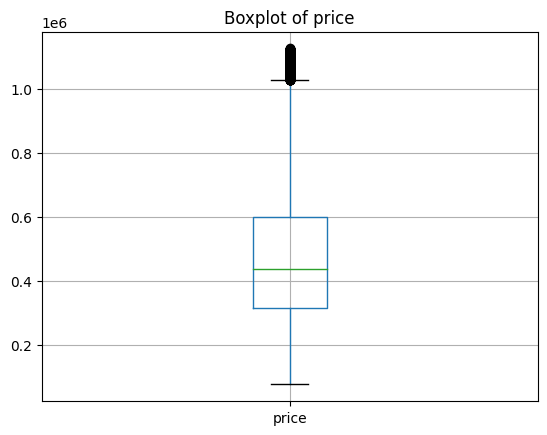

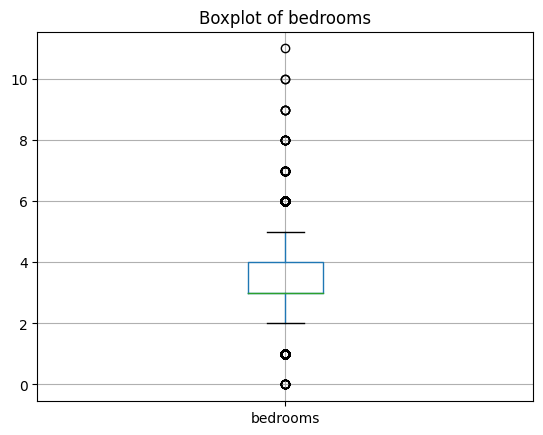

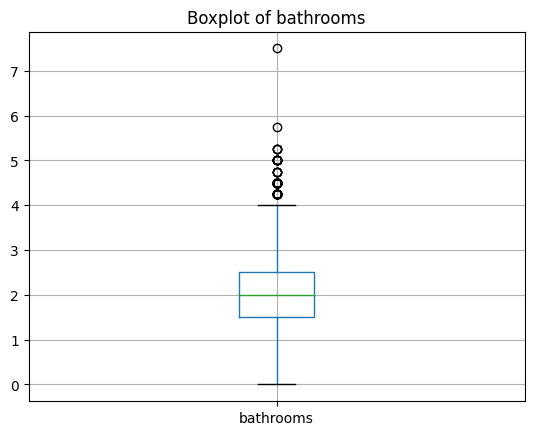

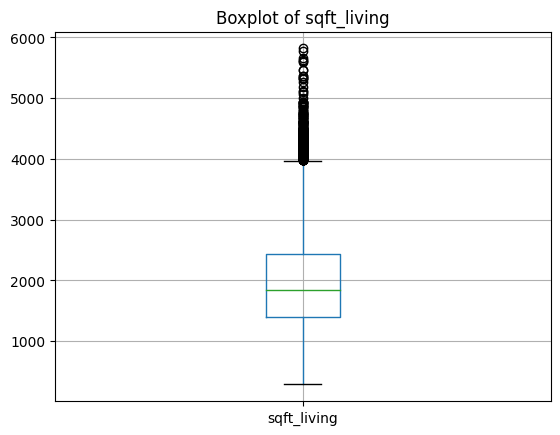

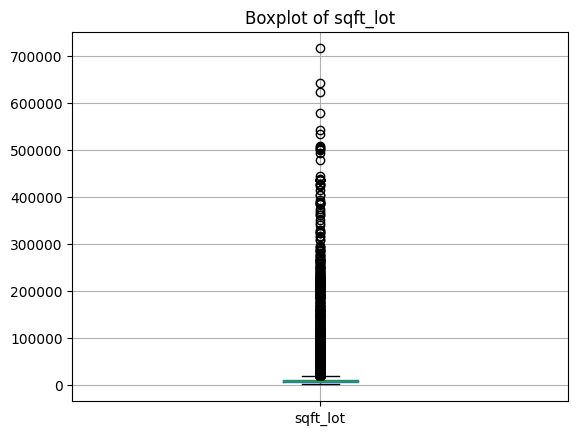

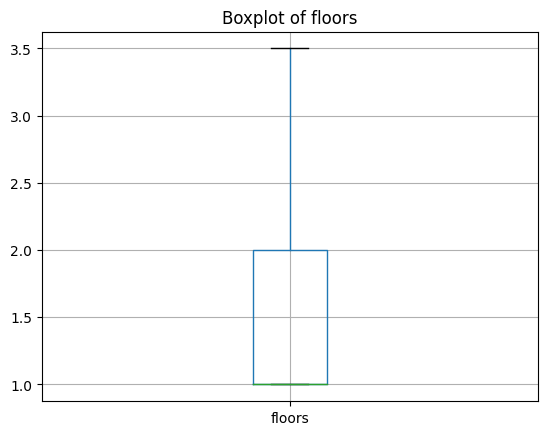

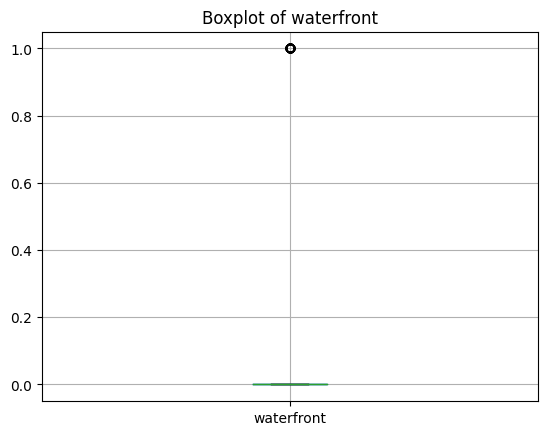

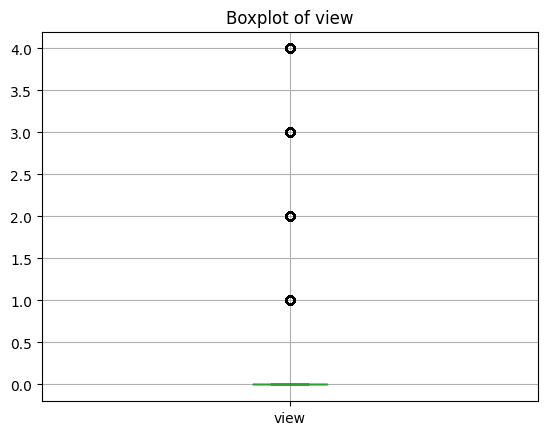

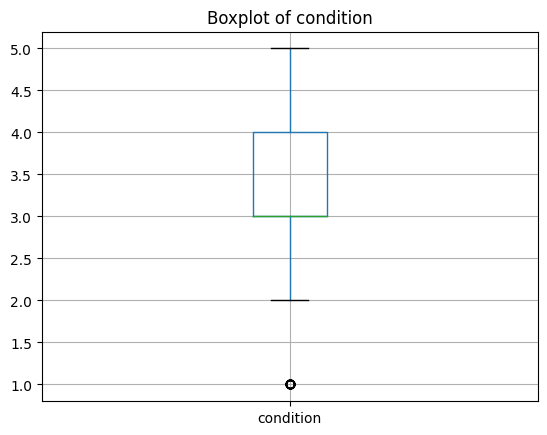

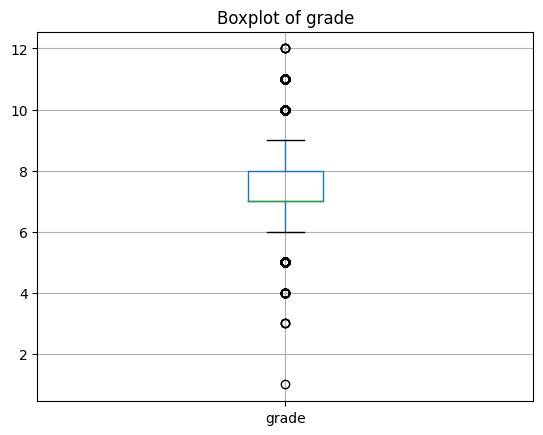

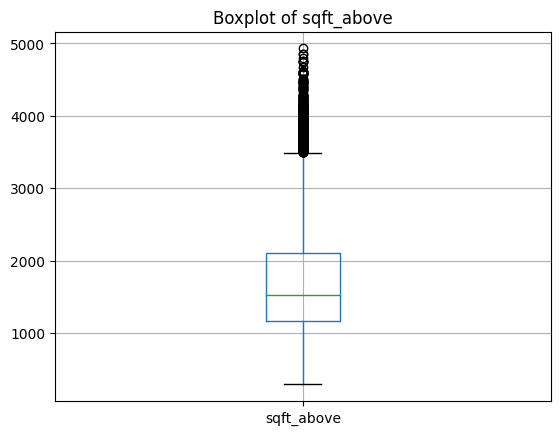

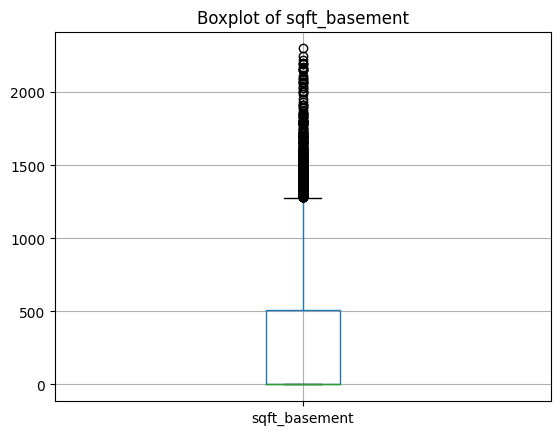

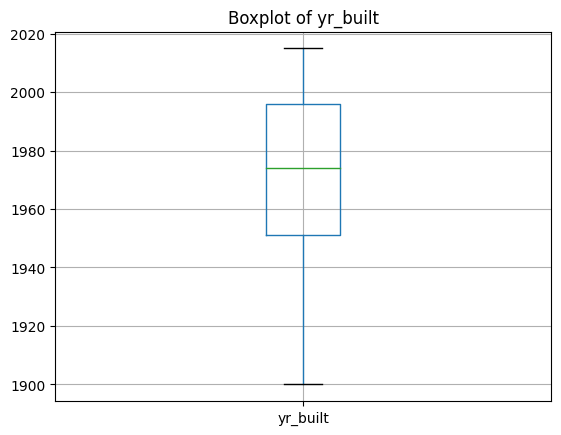

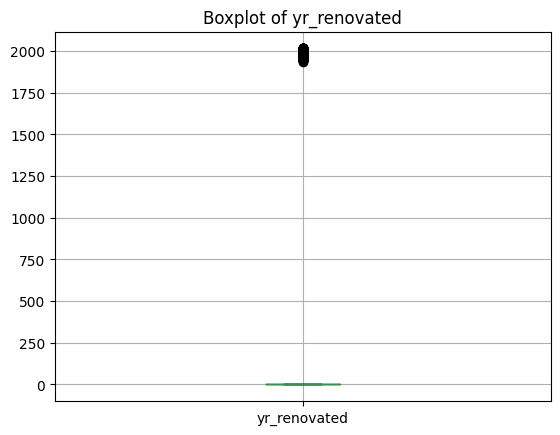

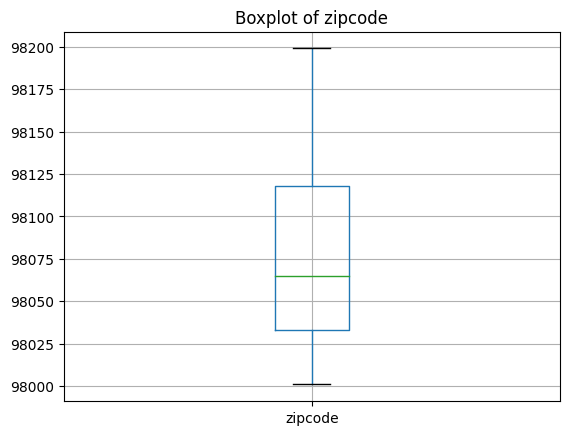

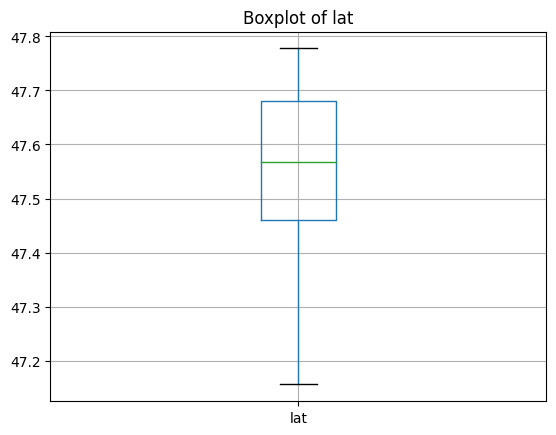

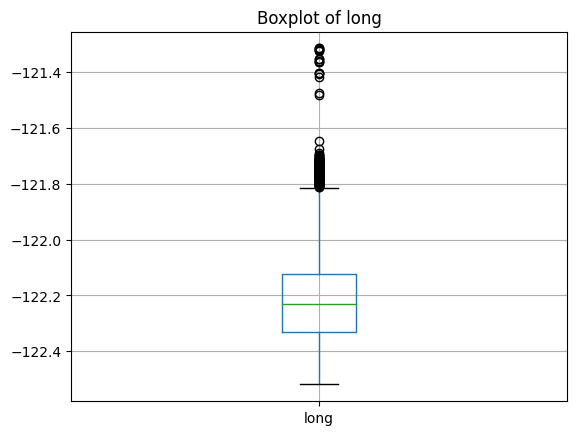

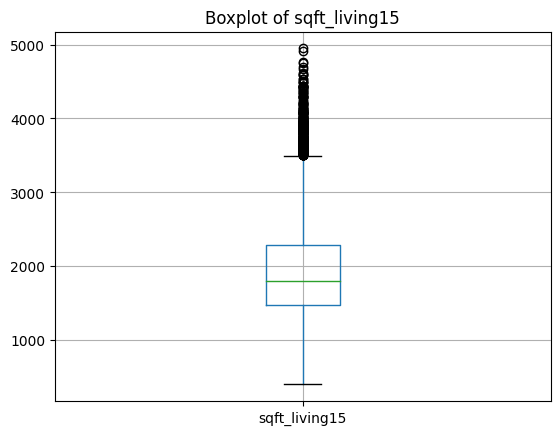

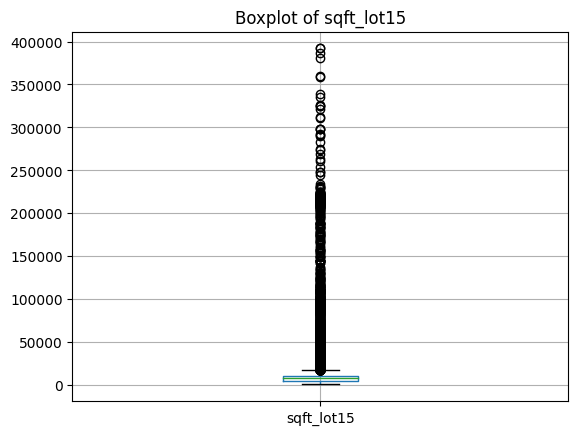

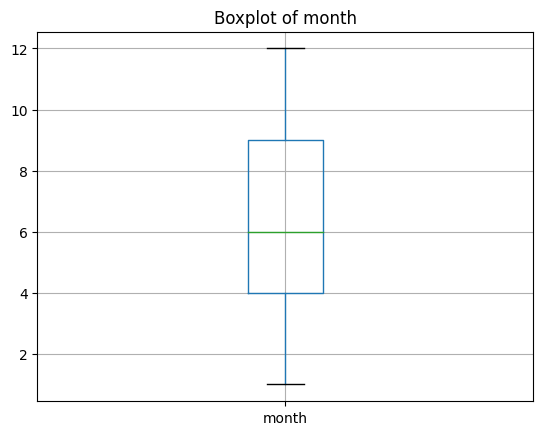

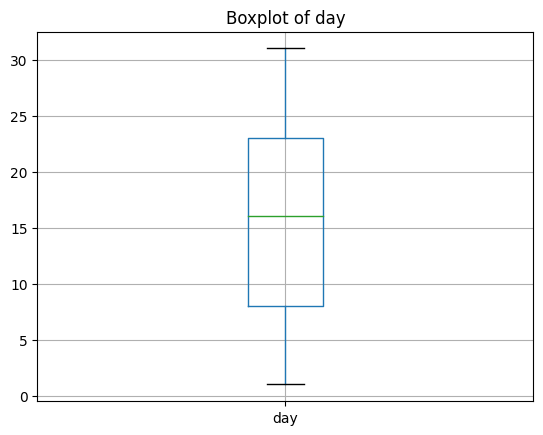

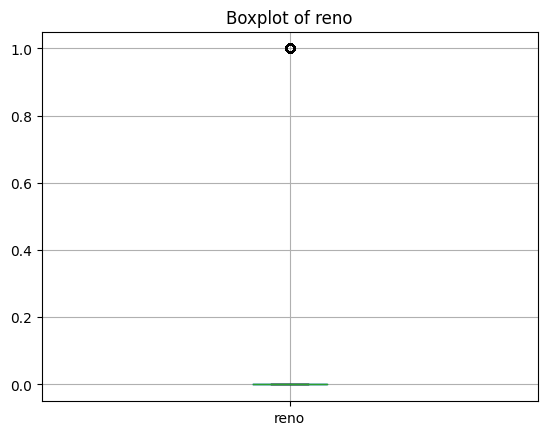

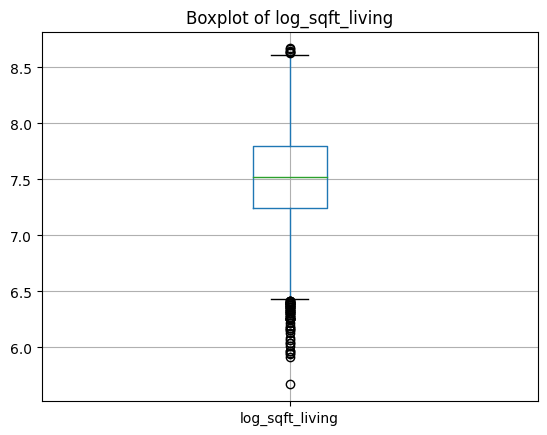

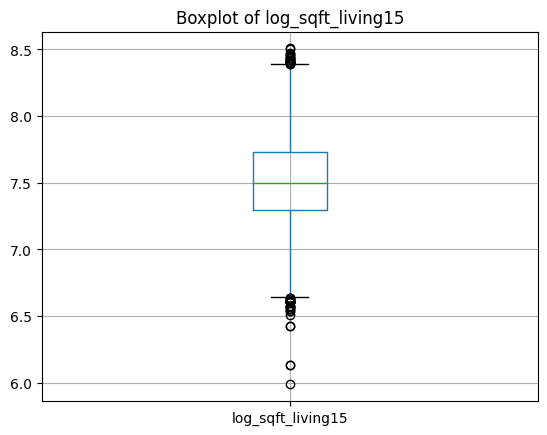

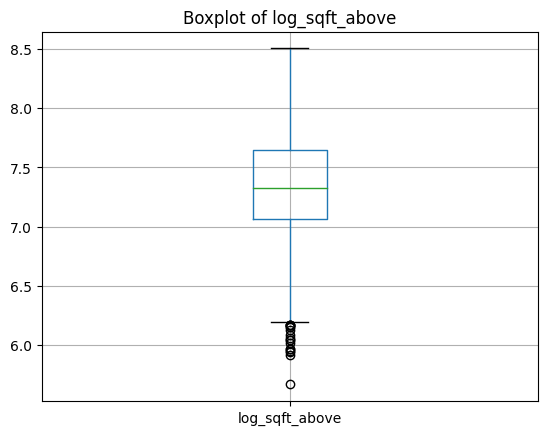

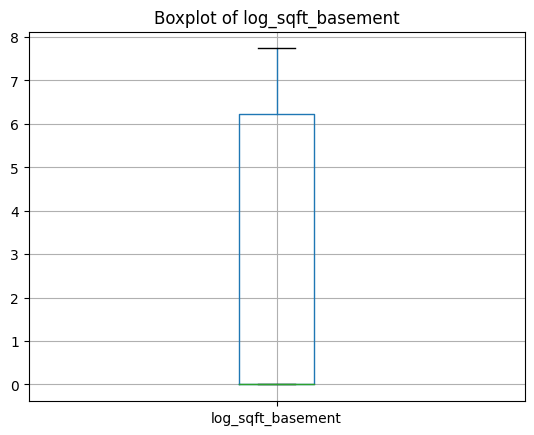

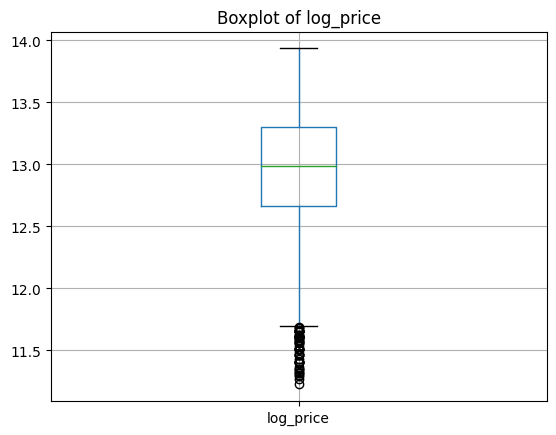

In [701]:
numerical_columns = house_t2.select_dtypes(include=['int', 'float']).columns

# Create separate boxplots for numerical columns
for column in numerical_columns:
    plt.figure()  # Create a new figure for each boxplot
    house_t2.boxplot(column=column)
    plt.title(f"Boxplot of {column}")  # Set the title for each boxplot
    plt.show()

In [641]:
# remove outliers for other columns

house_t2 = house_t2.drop(house_t2[house_t2['bedrooms'] > 30].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_living'] > 6000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_lot'] > 0.75*1000000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_above'] > 5000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_basement'] > 2500].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_living15'] > 5000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_lot15'] > 400000].index)

house_t2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20439 entries, 0 to 20466
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20439 non-null  datetime64[ns]
 1   price          20439 non-null  float64       
 2   bedrooms       20439 non-null  int64         
 3   bathrooms      20439 non-null  float64       
 4   sqft_living    20439 non-null  int64         
 5   sqft_lot       20439 non-null  int64         
 6   floors         20439 non-null  float64       
 7   waterfront     20439 non-null  int64         
 8   view           20439 non-null  int64         
 9   condition      20439 non-null  int64         
 10  grade          20439 non-null  int64         
 11  sqft_above     20439 non-null  int64         
 12  sqft_basement  20439 non-null  int64         
 13  yr_built       20439 non-null  int64         
 14  yr_renovated   20439 non-null  int64         
 15  zipcode        20439 non

### Cleaned dataframe finalized

In [642]:
house_cleaned = house_t2

In [643]:
house_cleaned

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,reno
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,13,0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,9,1
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,25,0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,12,9,0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20462,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5,21,0
20463,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2,23,0
20464,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,6,23,0
20465,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,1,16,0


<Axes: xlabel='sqft_living', ylabel='price'>

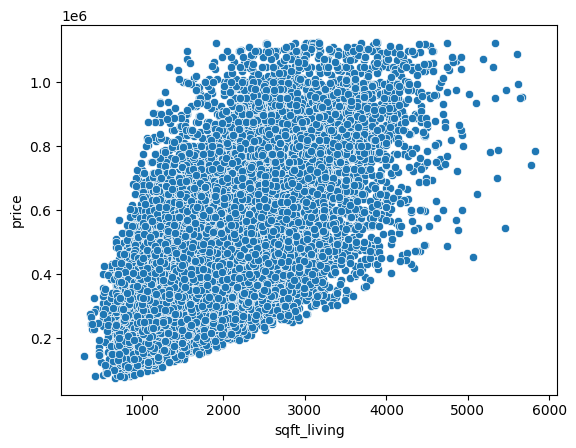

In [644]:
sns.scatterplot(x= 'sqft_living', y= 'price', data= house_cleaned)

<Axes: xlabel='sqft_living15', ylabel='price'>

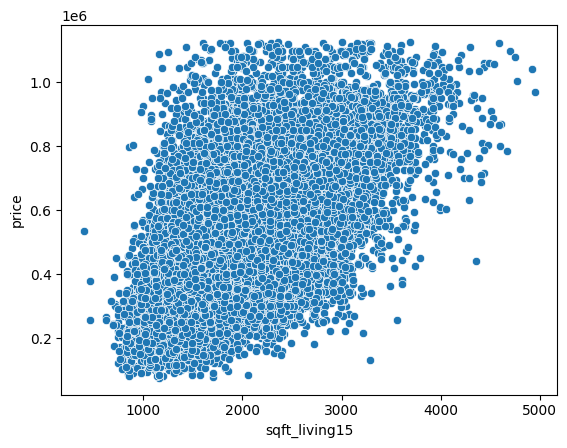

In [645]:
sns.scatterplot(x= 'sqft_living15', y= 'price', data= house_cleaned)

<Axes: xlabel='sqft_lot', ylabel='price'>

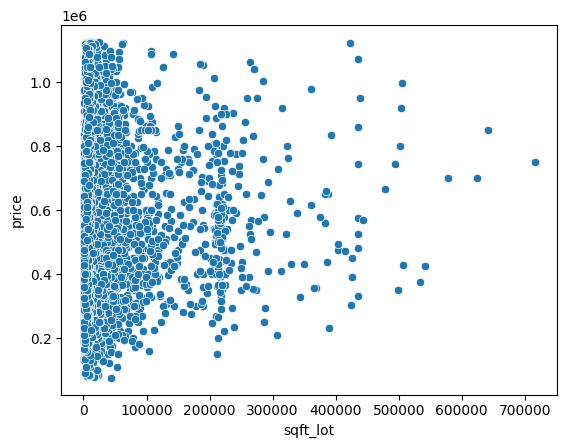

In [646]:
sns.scatterplot(x= 'sqft_lot', y= 'price', data= house_cleaned)

<Axes: xlabel='sqft_lot15', ylabel='price'>

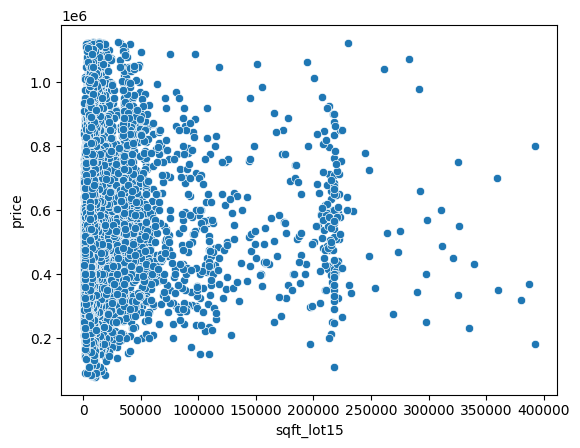

In [647]:
sns.scatterplot(x= 'sqft_lot15', y= 'price', data= house_cleaned)

In [648]:
column_names = house_cleaned.columns.tolist()
print(column_names)

['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'day', 'reno']


                   date     price  bedrooms  bathrooms  sqft_living  sqft_lot   
date           1.000000 -0.009410 -0.014389  -0.036568    -0.036898  0.000221  \
price         -0.009410  1.000000  0.302112   0.453437     0.621289  0.096282   
bedrooms      -0.014389  0.302112  1.000000   0.505473     0.601711  0.025464   
bathrooms     -0.036568  0.453437  0.505473   1.000000     0.714121  0.066452   
sqft_living   -0.036898  0.621289  0.601711   0.714121     1.000000  0.170217   
sqft_lot       0.000221  0.096282  0.025464   0.066452     0.170217  1.000000   
floors        -0.022187  0.273262  0.158355   0.501425     0.341005 -0.021842   
waterfront    -0.004128  0.051696 -0.031265  -0.003513     0.002111  0.030476   
view           0.001308  0.236319  0.037642   0.093042     0.163922  0.081481   
condition     -0.050379  0.039208  0.023669  -0.135296    -0.071428 -0.003129   
grade         -0.044473  0.629522  0.330306   0.612040     0.703921  0.102285   
sqft_above    -0.030223  0.5

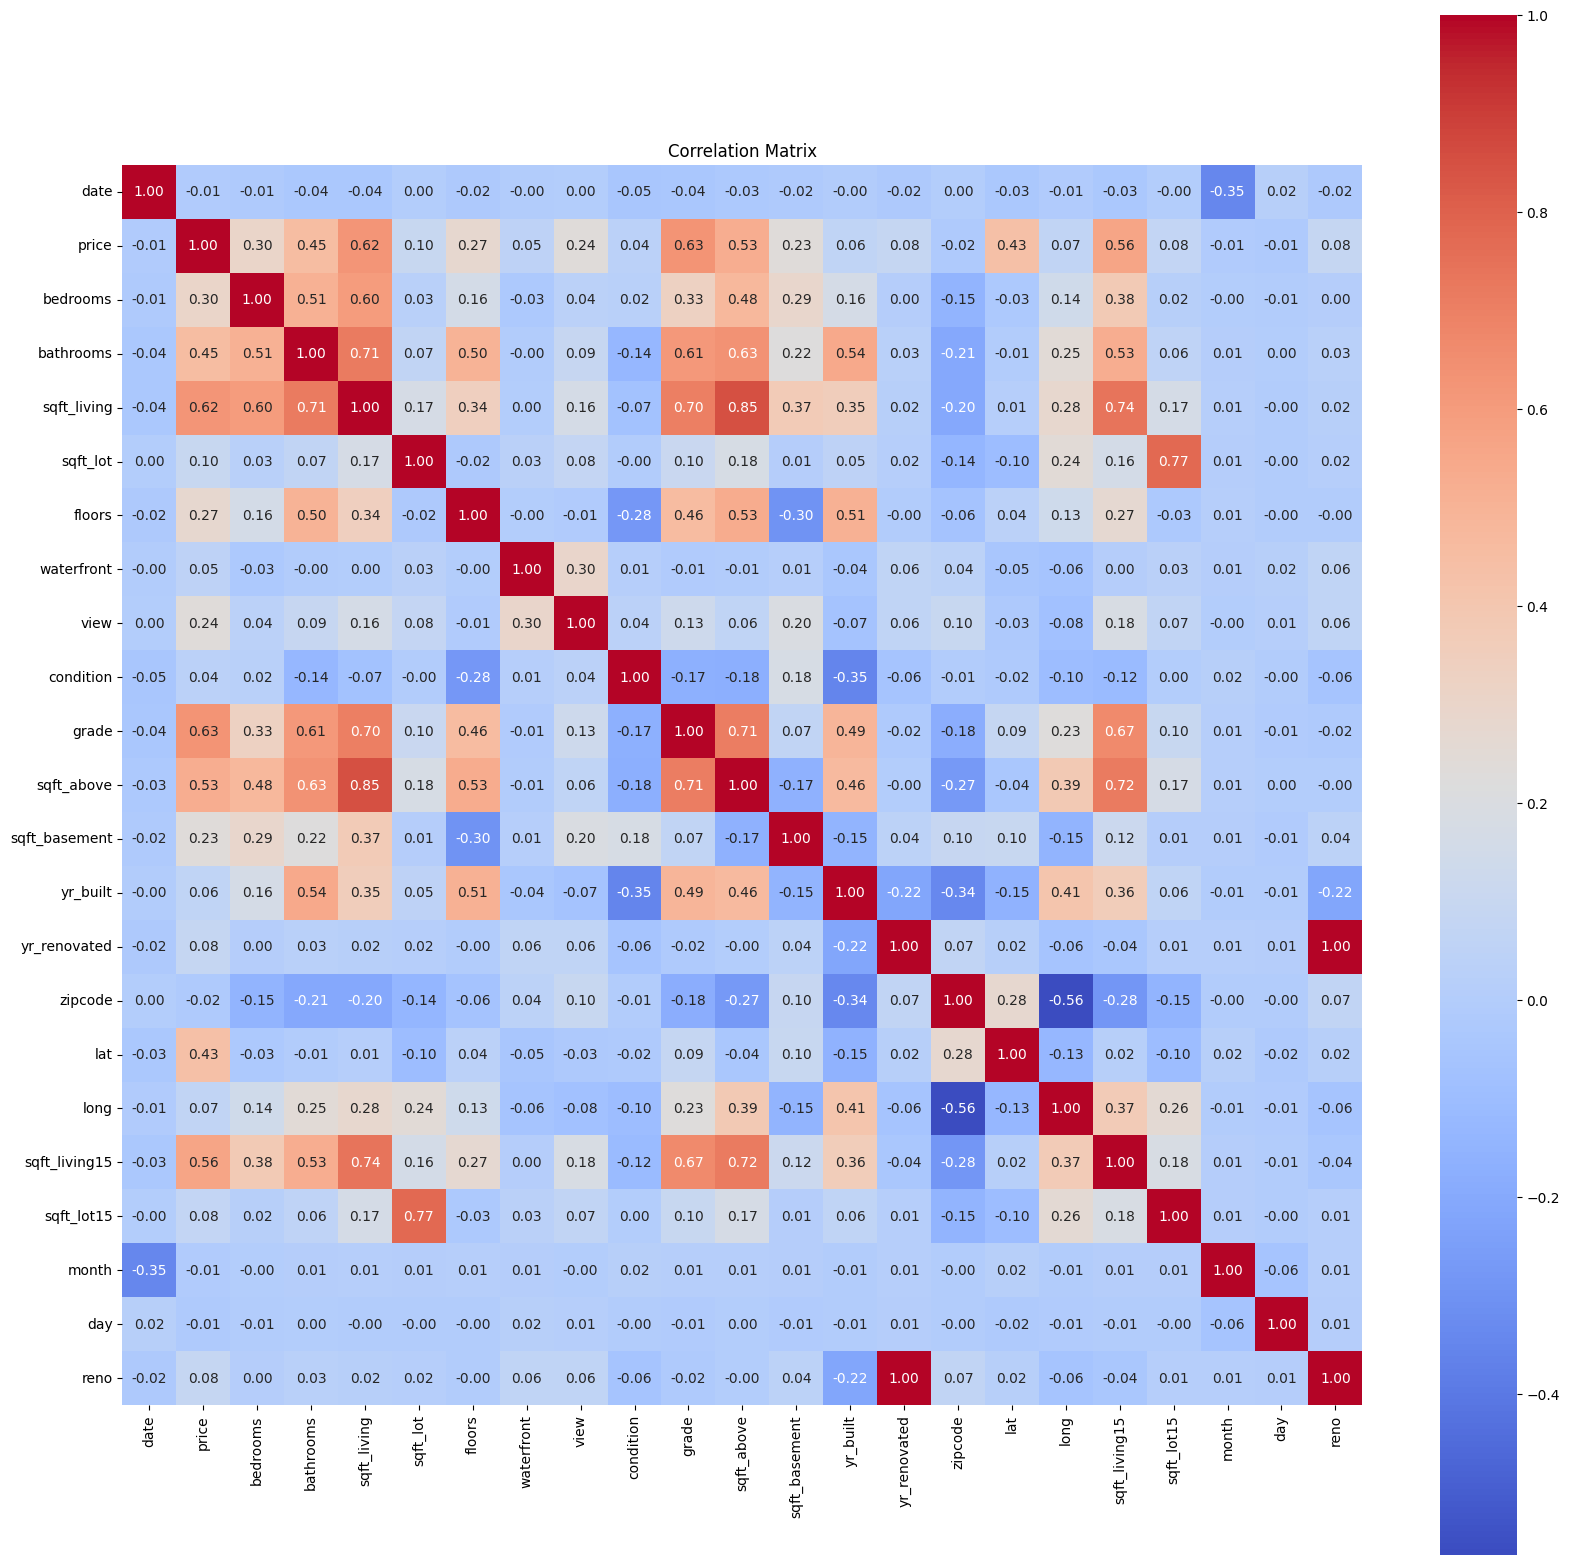

In [649]:
# Get all column names as a list
column_names = house_cleaned.columns.tolist()


# Combine all column names into a single variable
correlation_matrix = house_cleaned[column_names].corr()

print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

### From the heatmap, we can see the 'sqft_living', 'bathrooms', 'grade', 'sqft_above' and 'sqft_living15' is having a relatively strong correlation with the price. So I put them into the ols model.

In [650]:
results = ols("price ~ sqft_living + bathrooms + grade + sqft_above + sqft_living15", data=house_cleaned).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     3702.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:16:16   Log-Likelihood:            -2.7269e+05
No. Observations:               20439   AIC:                         5.454e+05
Df Residuals:                   20433   BIC:                         5.454e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.206e+05   8869.124    -36.151

### The R sq is 0.475 which I think can be larger, therefore I try to add the remaining varibles which have relatively high correlations: bedrooms, sqft_basemnet, view. Besides, I also find that 'yr_built' is having high correlation with 'grade' (0.49) and 'sqft_above' (0.46), so I put it in the model.

In [651]:
results = ols("price ~ sqft_living + bathrooms + grade + sqft_above + sqft_living15 + bedrooms + view+ sqft_basement + yr_built", data=house_cleaned).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     3340.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:16:16   Log-Likelihood:            -2.7074e+05
No. Observations:               20439   AIC:                         5.415e+05
Df Residuals:                   20430   BIC:                         5.416e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.701e+06   8.22e+04     57.191

### R sq increased to 0.567. I think this is good enough

In [653]:
# run the predicted values

pred_vals1 = results.predict(house_cleaned[['sqft_living', 'bathrooms', 'grade', 'sqft_above', 'sqft_living15', 'bedrooms', 'view', 'sqft_basement', 'yr_built']])

In [654]:
# create the residual

res1 = pd.concat([pred_vals1.to_frame().rename(columns={0:'y_hat'}),house_cleaned['price']], axis=1)

In [655]:
# create error column

res1['error'] = res1['y_hat'] - res1['price']

In [656]:
# calculate the MSE of the model

res1['sq_error'] = res1['error']**2

mse_1 = np.sqrt(res1['sq_error'].mean())

print(mse_1)

136917.43353778252


In [657]:
price_mean_1 = house_cleaned['price'].mean()

print(price_mean_1)

476521.72943881794


In [658]:
# error percentage

mse_1/price_mean_1

0.28732673680804677

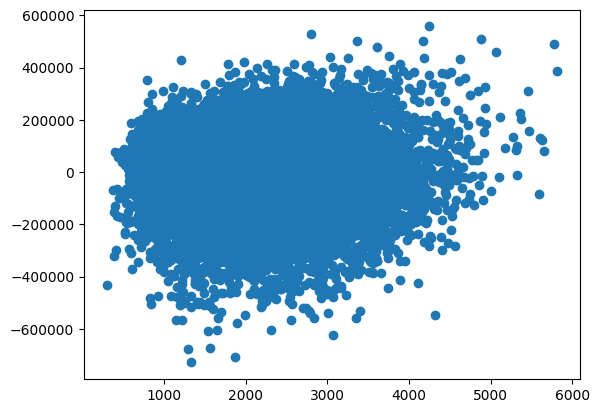

In [659]:
plt.scatter(house_cleaned['sqft_living'],res1['error'])

((array([-3.98379009, -3.76788988, -3.64976171, ...,  3.64976171,
          3.76788988,  3.98379009]),
  array([-728820.09681658, -708777.88034763, -679021.69010811, ...,
          509712.96812536,  527990.76377744,  557494.5096214 ])),
 (136277.20847484298, 1.236126159075299e-08, 0.9951376111738922))

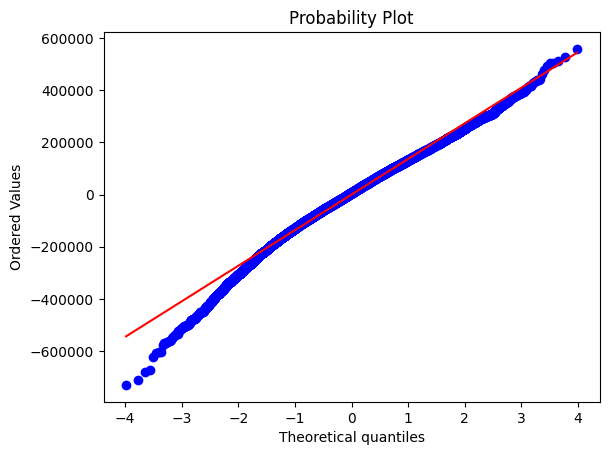

In [660]:
# plot the qq plot

import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res1['error'], dist='norm', plot=ax)

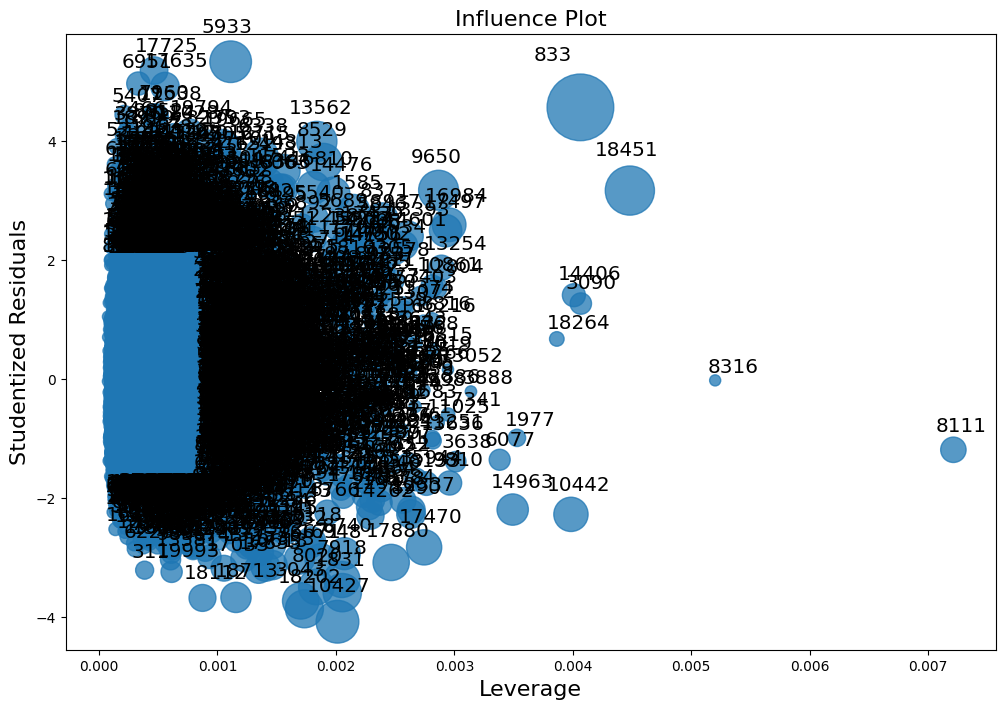

In [661]:
# plot influence plot

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion='cooks')

### The first model is having a high error (28% of the mean), non - normally distributed error. Therefore, I want to create a new model using a daily dataset.


Daily Dataset

In [662]:
daily_dataset = house_cleaned.set_index('date').resample("D").agg({
    'price' : 'mean',
    'sqft_living': 'mean',
    'bathrooms': 'mean',
    'grade': 'mean',
    'sqft_above': 'mean',
    'sqft_living15': 'mean',
    'bedrooms': 'mean',
    'sqft_basement': 'mean',
    'yr_built': 'mean',
    'view': 'mean'
})

In [663]:
results_1 = ols("price ~ sqft_living + bathrooms + grade + sqft_above + sqft_living15 + bedrooms + view+ sqft_basement + yr_built", data=daily_dataset).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     3340.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:21:10   Log-Likelihood:            -2.7074e+05
No. Observations:               20439   AIC:                         5.415e+05
Df Residuals:                   20430   BIC:                         5.416e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.701e+06   8.22e+04     57.191

In [664]:
# create predicted value of the second model

pred_vals2 = results_1.predict(daily_dataset[['sqft_living', 'bathrooms', 'grade', 'sqft_above', 'sqft_living15', 'bedrooms', 'view', 'sqft_basement', 'yr_built']])

In [665]:
# create residual table
res2 = pd.concat([pred_vals2.to_frame().rename(columns={0:'y_hat'}),daily_dataset['price']], axis=1)

# create error column
res2['error'] = res2['y_hat'] - res2['price']

# calculate the MSE
res2['sq_error'] = res2['error']**2

mse_2 = np.sqrt(res2['sq_error'].mean())

print(mse_2)

47511.61017816942


In [666]:
price_mean_2 = daily_dataset['price'].mean()

print(price_mean_2)

479020.8724741965


In [667]:
# error percentage 2

mse_2/price_mean_2

0.09918484330915818

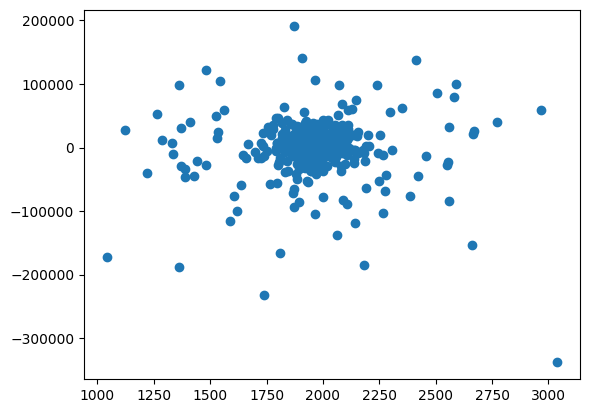

In [668]:
plt.scatter(daily_dataset['sqft_living'],res2['error'])

((array([-2.91387448, -2.62501443, -2.46205562, -2.34623554, -2.25530942,
         -2.17991574, -2.11519298, -2.05827964, -2.00734358, -1.96113835,
         -1.91877606, -1.87960101, -1.84311466, -1.8089288 , -1.77673494,
         -1.74628377, -1.71737077, -1.68982602, -1.66350676, -1.63829182,
         -1.61407745, -1.59077411, -1.56830394, -1.54659883, -1.52559882,
         -1.50525083, -1.48550766, -1.46632712, -1.44767135, -1.42950625,
         -1.41180096, -1.39452751, -1.3776604 , -1.36117637, -1.34505414,
         -1.32927412, -1.31381835, -1.29867019, -1.28381432, -1.2692365 ,
         -1.25492353, -1.24086313, -1.22704385, -1.21345501, -1.20008662,
         -1.18692934, -1.17397438, -1.16121351, -1.14863898, -1.13624349,
         -1.12402017, -1.11196253, -1.10006442, -1.08832003, -1.07672387,
         -1.06527072, -1.05395562, -1.04277388, -1.03172103, -1.02079279,
         -1.00998513, -0.99929417, -0.98871622, -0.97824776, -0.96788543,
         -0.95762599, -0.94746638, -0.

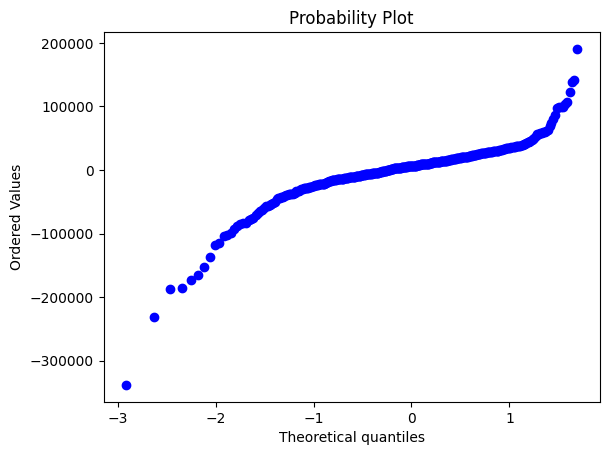

In [669]:
import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res2['error'], dist='norm', plot=ax)

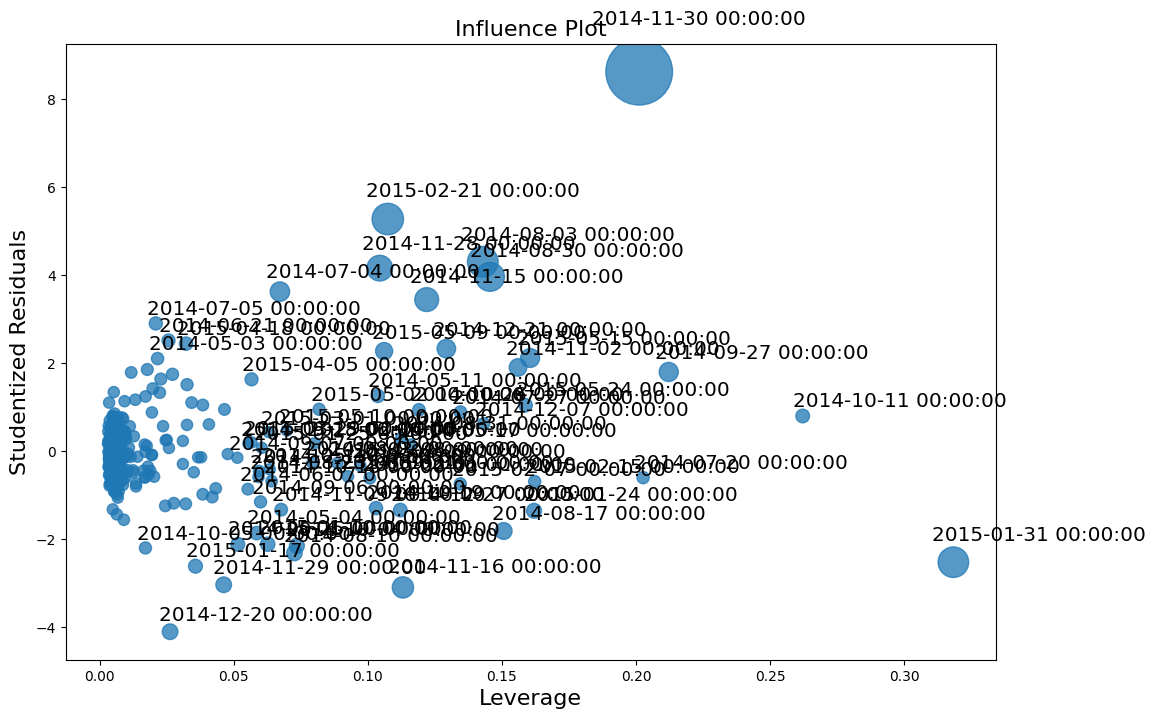

In [670]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results_1, ax=ax, criterion='cooks')

### Using the daily database approach can reduce the error (9.9% of the mean), however the error is not normally distributed. Therefore, I try to use the third approach of taking a logrithm for all the numeric factors in the model.

['sqft_living', 'bathrooms', 'grade', 'sqft_above', 'sqft_living15', 'bedrooms', 'view', 'sqft_basement', 'yr_built', 'reno']

### Logrithm

In [671]:
house_cleaned_t1 = house_cleaned

In [672]:
# Compute logarithm with a check for zero or negative values
def safe_log(x):
    return np.log(x) if x > 0 else 0

# Apply safe_log function to avoid divide by zero warning
house_cleaned_t1['log_sqft_living'] = house_cleaned_t1['sqft_living'].apply(safe_log)

house_cleaned_t1['log_sqft_living15'] = house_cleaned_t1['sqft_living15'].apply(safe_log)

house_cleaned_t1['log_sqft_above'] = house_cleaned_t1['sqft_above'].apply(safe_log)

house_cleaned_t1['log_sqft_basement'] = house_cleaned_t1['sqft_basement'].apply(safe_log)

house_cleaned_t1['log_price'] = house_cleaned_t1['price'].apply(safe_log)

In [673]:
results_2 = ols("log_price ~ log_sqft_living + bathrooms + grade + log_sqft_above + log_sqft_living15 + bedrooms + view + log_sqft_basement + yr_built", data=house_cleaned_t1).fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     2687.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:21:12   Log-Likelihood:                -4498.2
No. Observations:               20439   AIC:                             9016.
Df Residuals:                   20429   BIC:                             9096.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            18.2351      0.19

In [674]:
pred_vals3 = results_2.predict(house_cleaned_t1[['log_sqft_living', 'bathrooms', 'grade', 'log_sqft_above', 'log_sqft_living15', 'bedrooms', 'view', 'log_sqft_basement', 'yr_built']])

In [675]:
res3 = pd.concat([pred_vals3.to_frame().rename(columns={0:'y_hat'}),house_cleaned_t1['log_price']], axis=1)

res3['error'] = res3['y_hat'] - res3['log_price']

res3['sq_error'] = res3['error']**2

mse_3 = np.sqrt(res3['sq_error'].mean())

print(mse_3)

0.3015382869233124


In [676]:
price_mean_3 = house_cleaned_t1['log_price'].mean()

print(price_mean_3)

12.978315363064311


In [702]:
# calculate MSE

mse_3/price_mean_3

0.023234008304458105

((array([-3.98379009, -3.76788988, -3.64976171, ...,  3.64976171,
          3.76788988,  3.98379009]),
  array([-1.22747763, -1.22535572, -1.1944974 , ...,  1.19476122,
          1.21083044,  1.32641612])),
 (0.30092736675207044, -1.8952771046405736e-13, 0.9977870967105826))

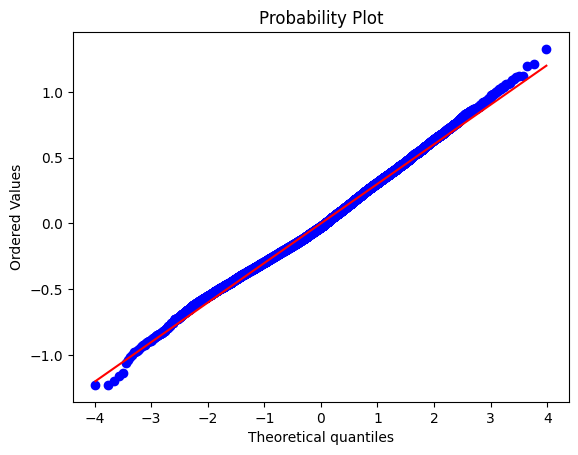

In [678]:
# plot the qq plot

import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res3['error'], dist='norm', plot=ax)

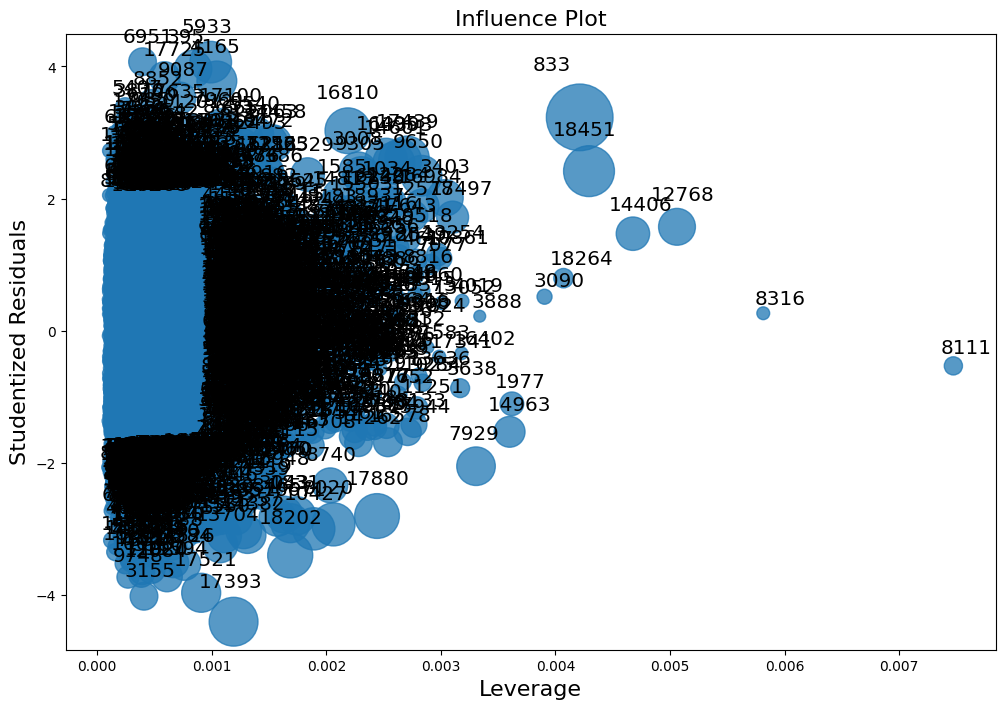

In [700]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results_2, ax=ax, criterion='cooks')

In [679]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.impute import SimpleImputer
import numpy as np

'log_sqft_living', 'bathrooms', 'grade', 'log_sqft_above', 'log_sqft_living15', 'bedrooms', 'view', 'log_sqft_basement', 'yr_built'

In [680]:
# separate features and target
categorical_features = ['bedrooms','bathrooms','grade','yr_built','view']
numerical_features = ['log_sqft_living','log_sqft_living15','log_sqft_above','log_sqft_basement'] 
target = 'log_price'

In [681]:
# split data in train / test
X_train, X_test, y_train, y_test = train_test_split(house_cleaned_t1[categorical_features + numerical_features]
                                                    ,house_cleaned_t1[target],
                                                    test_size = 0.3, random_state=1234)

In [682]:
# define transformers
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps = [('scaler', StandardScaler())])

In [683]:
# building processor
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, categorical_features),
                                                 ('num', num_transformer, numerical_features)])

### Linear Regression Model

In [684]:
# build linear regression model

linear_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [685]:
# fit the data into the model

linear_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bedrooms', 'bathrooms',
                                                   'grade', 'yr_built',
                                                   'view']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_sqft_living15',
                                                   'log_sqft_above',
                                                   'log_sqft_basement'])])),
                ('regressor', LinearRegression())])

In [686]:
# predict values

pred = linear_regression.predict(X_test)

In [687]:
# calculate MSE

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(pred,y_test))

0.2911731298042678

### Ridge Regression Model

In [688]:
# build ridge regression model

ridge_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=3.0))
])

In [689]:
# fit the data into the model

ridge_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bedrooms', 'bathrooms',
                                                   'grade', 'yr_built',
                                                   'view']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_sqft_living15',
                                                   'log_sqft_above',
                                                   'log_sqft_basement'])])),
                ('regressor', Ridge(alpha=3.0))])

In [690]:
# predict values

pred_ridge = ridge_regression.predict(X_test)

In [691]:
# calculate MSE

np.sqrt(mean_squared_error(pred_ridge,y_test))

0.2913326356025269

### Lasso Regression Model

In [692]:
# build lasso regression model

lasso_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))
])

In [693]:
# fit the data into the model

lasso_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bedrooms', 'bathrooms',
                                                   'grade', 'yr_built',
                                                   'view']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_sqft_living15',
                                                   'log_sqft_above',
                                                   'log_sqft_basement'])])),
                ('regressor', Lasso())])

In [694]:
# predict values

lasso_pred = lasso_regression.predict(X_test)

In [695]:
# calculate MSE

np.sqrt(mean_squared_error(lasso_pred, y_test))

0.44887254749653643

### Elasticnet Regression Model

In [696]:
# build elasticnet regression model

elasticnet_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.8))
])

In [697]:
# fit the data into the model

elasticnet_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bedrooms', 'bathrooms',
                                                   'grade', 'yr_built',
                                                   'view']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_sqft_living15',
                                                   'log_sqft_above',
                                                   'log_sqft_basement'])])),
                ('regressor', ElasticNet(l1_ratio=0.8))])

In [698]:
# predict values

elasticnet_pred = elasticnet_regression.predict(X_test)

In [699]:
# calculate MSE

np.sqrt(mean_squared_error(elasticnet_pred, y_test))

0.44887254749653643